In [1]:
!pip install gymnasium
!pip install stable-baselines3==2.0.0 
!pip install numpy==1.24.4
!pip install swig
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 #this line should change for mac, you can find it on pytorch 

  Using cached numpy-1.24.4.tar.gz (10.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\irmak\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\irmak\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\irmak\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\irmak\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^

ERROR: Invalid requirement: '#this': Expected package name at the start of dependency specifier
    #this
    ^


In [2]:
try:
  !rm -rf boptestGymService
except:
  pass
!git clone -b boptest-gym-service https://github.com/ibpsa/project1-boptest-gym.git boptestGymService

Cloning into 'boptestGymService'...


In [3]:
import json
import sys
import numpy as np
import requests
import gymnasium as gym

In [4]:
sys.path.insert(0,'boptestGymService')
from boptestGymEnv import BoptestGymEnv

# url for the BOPTEST service
url = 'https://api.boptest.net'
TEST_CASE = "bestest_hydronic_heat_pump"

C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:122: SyntaxWarning: invalid escape sequence '\c'
  axs[0].set_ylabel('Operative\ntemperature\n($^\circ$C)')
C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:131: SyntaxWarning: invalid escape sequence '\c'
  axs[3].set_ylabel('Ambient\ntemperature\n($^\circ$C)')
C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:135: SyntaxWarning: invalid escape sequence '\d'
  axt.plot(x_time, df['weaSta_reaWeaHDirNor_y'], color='gold', linestyle='-', linewidth=1, label='$\dot{Q}_rad$')
C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:141: SyntaxWarning: invalid escape sequence '\d'
  axs[3].plot([],[], color='gold',        linestyle='-', linewidth=1, label='$\dot{Q}_{rad}$')


In [5]:
# Instantiate environment
env = BoptestGymEnv(url                   = url,
                    testcase              = 'bestest_hydronic_heat_pump',
                    actions               = ['oveHeaPumY_u'],
                    observations          = {'reaTZon_y':(280.,310.)},
                    random_start_time     = False,
                    start_time            = 31*24*3600,
                    max_episode_length    = 24*3600,
                    warmup_period         = 0,
                    step_period           = 3600)

C:\Users\irmak\anaconda3\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [6]:
env?

Type:           BoptestGymEnv
String form:   
           BOPTEST CASE INFORMATION
           
           Test case name
           ----- <...> v.BoptestGymEnv'>,
           <class 'gymnasium.core.Env'>,
           <class 'typing.Generic'>,
           <class 'object'>)
           
           
File:           c:\users\irmak\documents\github\rl_ex\boptestgymservice\boptestgymenv.py
Docstring:     
BOPTEST Environment that follows gym interface.
This environment allows the interaction of RL agents with building
emulator models from BOPTEST. 
 
Init docstring:
Parameters
----------
url: string
    Rest API url for communication with the BOPTEST interface
testcase: string
    The string identifier of the testcase
actions: list
    List of strings indicating the action space. The bounds of 
    each variable from the action space the are retrieved from 
    the overwrite block attributes of the BOPTEST test case
observations: dictionary
    Dictionary mapping observation keys to a tuple with 

In [7]:
obs, _ = env.reset()
print('Zone temperature: {:.2f} degC'.format(obs[0]-273.15))
print('Episode starting day: {:.1f} (from beginning of the year)'.format(env.start_time/24/3600))

Zone temperature: 20.00 degC
Episode starting day: 31.0 (from beginning of the year)


In [8]:
print('Observation space of the building environment:')
print(env.observation_space)
print('Action space of the building environment:')
print(env.action_space)

Observation space of the building environment:
Box(280.0, 310.0, (1,), float32)
Action space of the building environment:
Box(0.0, 1.0, (1,), float32)


In [9]:
print(env)


BOPTEST CASE INFORMATION

Test case name
--------------
{'name': 'bestest_hydronic_heat_pump'}

All measurement variables
-------------------------
{'reaCO2RooAir_y': {'Description': 'CO2 concentration in the zone',
                    'Maximum': None,
                    'Minimum': None,
                    'Unit': 'ppm'},
 'reaCOP_y': {'Description': 'Heat pump COP',
              'Maximum': None,
              'Minimum': None,
              'Unit': '1'},
 'reaPFan_y': {'Description': 'Electrical power of the heat pump evaporator '
                              'fan',
               'Maximum': None,
               'Minimum': None,
               'Unit': 'W'},
 'reaPHeaPum_y': {'Description': 'Heat pump electrical power',
                  'Maximum': None,
                  'Minimum': None,
                  'Unit': 'W'},
 'reaPPumEmi_y': {'Description': 'Emission circuit pump electrical power',
                  'Maximum': None,
                  'Minimum': None,
                  '

In [10]:
from boptestGymEnv import DiscretizedActionWrapper
env = DiscretizedActionWrapper(env,n_bins_act=1)
print('Action space of the wrapped agent:')
print(env.action_space)
print('Action space of the original agent:')
print(env.unwrapped.action_space)

Action space of the wrapped agent:
Discrete(2)
Action space of the original agent:
Box(0.0, 1.0, (1,), float32)


env.unwrapped.stop()

In [12]:
#env.stop()

In [13]:
obs, _ = env.reset()

In [14]:
class Q_Learning_Agent(object):

  def __init__(self, env, eps_min=0.01, eps_decay=0.01, alpha=0.05, gamma=0.9):
    '''Constructor of a q-learning agent. Assumes discrete state and action spaces.

    '''
    self.env       = env
    self.eps_min   = eps_min
    self.eps_decay = eps_decay
    self.alpha     = alpha
    self.gamma     = gamma

    # Initialize epsilon
    self.eps       = 1.0

    # Initialize q-function as a null function
    self.q = np.zeros((env.observation_space.n,
                       env.action_space.n))

  def predict(self, obs, deterministic=True):
    '''Method to select an action with an epsilon-greedy policy.

    '''
    if deterministic:
      # Use q-function to decide action
      return np.argmax(self.q[obs])
    else:
      if self.eps > self.eps_min:
        # Linearly decreasing schedule
        self.eps -= self.eps_decay
      if np.random.random() < self.eps:
        # Explore with random action
        return np.random.choice([a for a in range(env.action_space.n)])
      else:
        # Exploit the information of our q-function
        return np.argmax(self.q[obs])

  def learn(self, total_episodes=10):
    '''Learn from a number of interactions with the environment.

    '''
    for i in range(total_episodes):
      # Initialize enviornment
      done = False
      obs, _  = env.reset()
      # Print episode number and starting day from beginning of the year:
      print('-------------------------------------------------------------------')
      print('Episode number: {0}, starting day: {1:.1f} ' \
            '(from beginning of the year)'.format(i+1, env.start_time/24/3600))

      while not done:
        # Get action with epsilon-greedy policy and simulate
        act                   = self.predict(obs, deterministic=False)
        nxt_obs, rew, terminated, truncated, _ = env.step(act)
        done = (terminated or truncated)
        # Compute temporal difference target and error to udpate q-function
        td_target         = rew + self.gamma*np.max(self.q[nxt_obs])
        td_error          = td_target - self.q[obs][act]
        self.q[obs][act] += self.alpha*td_error
        # Make our next observation the current observation
        obs = nxt_obs
      # Print the q-function after every episode to show progress
      print('q(s,a) = ')
      print(self.q)

In [15]:
# Redefine reward function
class BoptestGymEnvCustomReward(BoptestGymEnv):
    '''Define a custom reward for this building

    '''
    def get_reward(self):
        '''Custom reward function. To expedite learning, we use a clipped reward
        function that has a value of 1 when there is no increase in discomfort
        and 0 otherwise. We use the BOPTEST `GET /kpis` API call to compute the
        total cummulative discomfort from the beginning of the episode. Note
        that this is the true value that BOPTEST uses when evaluating
        controllers.

        '''
        # Compute BOPTEST core kpis
        kpis = requests.get('{0}/kpi/{1}'.format(self.url, self.testid)).json()['payload']
        # Calculate objective integrand function as the total discomfort
        objective_integrand = kpis['tdis_tot']
        # Give reward if there is not immediate increment in discomfort
        if objective_integrand == self.objective_integrand:
          reward=1
        else:
          reward=0
        # Record current objective integrand for next evaluation
        self.objective_integrand = objective_integrand
        return reward

In [16]:
env.stop()
import random

# Seed for random starting times of episodes
seed = 123456
random.seed(seed)
# Seed for random exploration and epsilon-greedy schedule
np.random.seed(seed)

# Winter period goes from December 21 (day 355) to March 20 (day 79)
excluding_periods = [(79*24*3600, 355*24*3600)]
# Temperature setpoints
lower_setp = 21 + 273.15
upper_setp = 24 + 273.15
# Instantiate environment
env = BoptestGymEnvCustomReward(url                   = url,
                                testcase              = 'bestest_hydronic_heat_pump',
                                actions               = ['oveHeaPumY_u'],
                                observations          = {'reaTZon_y':(lower_setp,upper_setp)},
                                random_start_time     = False,
                                start_time            = 31*24*3600,
                                excluding_periods     = excluding_periods,
                                max_episode_length    = 2*24*3600,
                                warmup_period         = 24*3600,
                                step_period           = 3600,
                                render_episodes       = True)

<Figure size 640x480 with 0 Axes>

In [17]:
from boptestGymEnv import DiscretizedObservationWrapper
from boptestGymEnv import DiscretizedActionWrapper

In [18]:
env = DiscretizedActionWrapper(env, n_bins_act=1)
env = DiscretizedObservationWrapper(env, n_bins_obs=3, outs_are_bins=True)

In [19]:
print('Observation space of the building environment:')
print(env.observation_space.sample())
print(env.observation_space)
print('Action space of the building environment:')
print(env.action_space)
print(env.action_space.sample())

Observation space of the building environment:
0
Discrete(3)
Action space of the building environment:
Discrete(2)
1


In [20]:
model = Q_Learning_Agent(env, eps_min=0.01, eps_decay=0.001, alpha=0.1, gamma=0.9)

-------------------------------------------------------------------
Episode number: 1, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


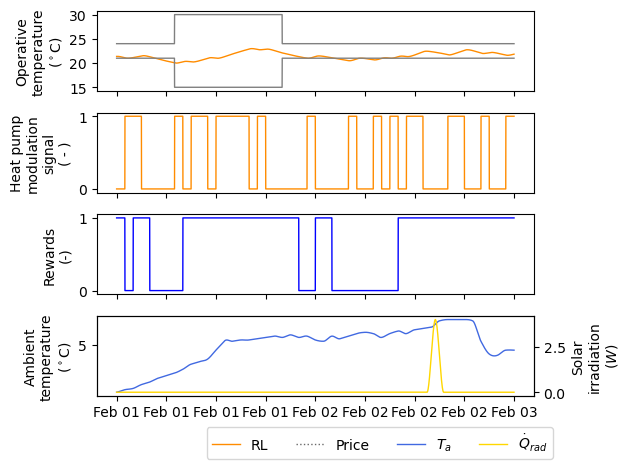

q(s,a) = 
[[0.26180316 0.24359508]
 [1.51394721 1.30415739]
 [0.         0.        ]]
-------------------------------------------------------------------
Episode number: 2, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


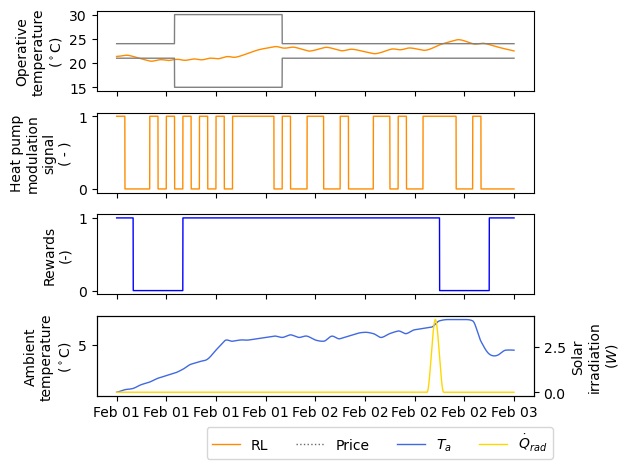

q(s,a) = 
[[0.46277171 0.62622087]
 [2.76083377 2.11424174]
 [0.43421035 0.        ]]
-------------------------------------------------------------------
Episode number: 3, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


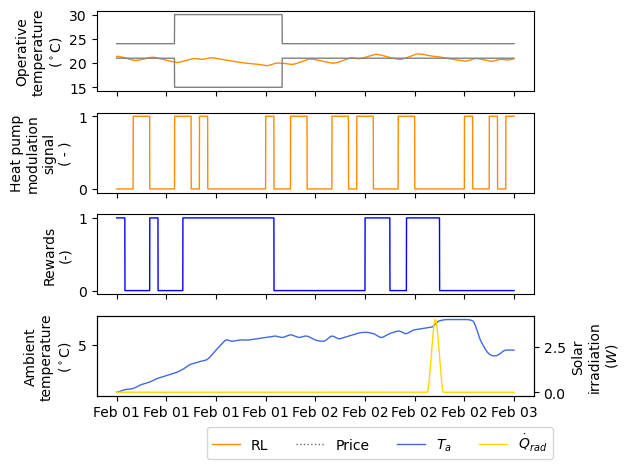

q(s,a) = 
[[1.21349702 1.28200585]
 [2.55296245 2.32700645]
 [0.43421035 0.        ]]
-------------------------------------------------------------------
Episode number: 4, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


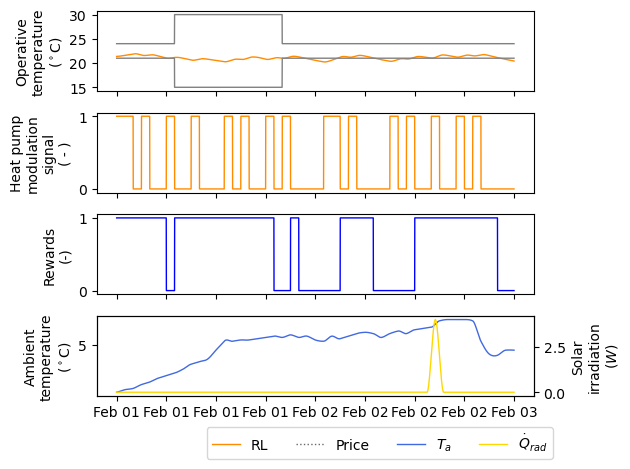

q(s,a) = 
[[1.64661858 1.98269733]
 [3.11554466 2.9625746 ]
 [0.43421035 0.        ]]
-------------------------------------------------------------------
Episode number: 5, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


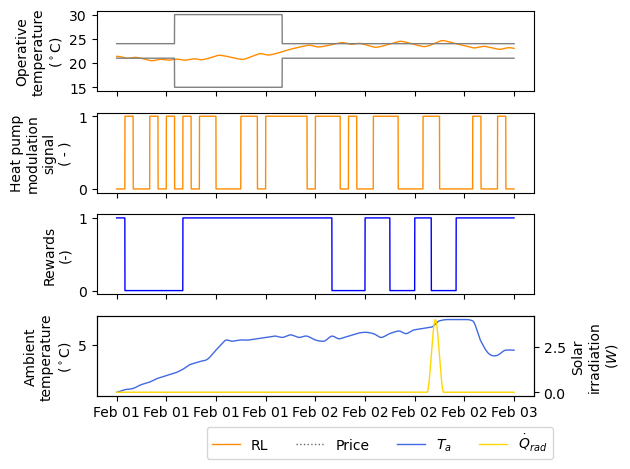

q(s,a) = 
[[1.79306988 2.42566044]
 [3.77410277 3.12352815]
 [1.31236709 0.        ]]
-------------------------------------------------------------------
Episode number: 6, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


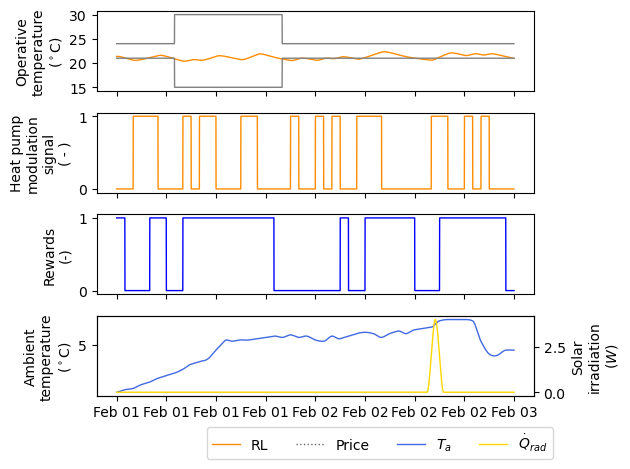

q(s,a) = 
[[2.25324244 3.01537425]
 [3.94838309 3.79176701]
 [1.31236709 0.        ]]
-------------------------------------------------------------------
Episode number: 7, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


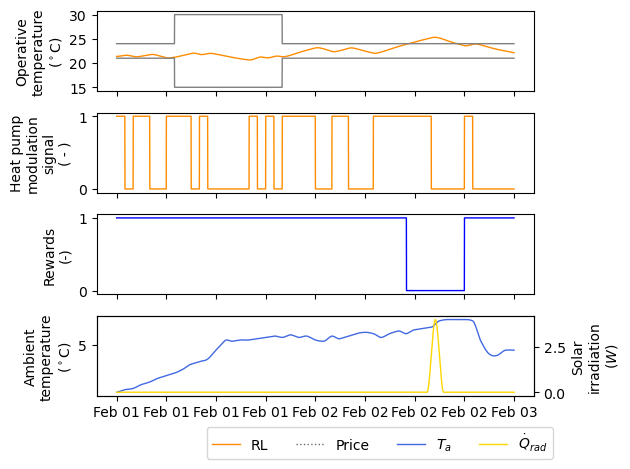

q(s,a) = 
[[2.39930188 3.20138449]
 [4.9851519  4.58753006]
 [1.57145336 0.22441477]]
-------------------------------------------------------------------
Episode number: 8, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


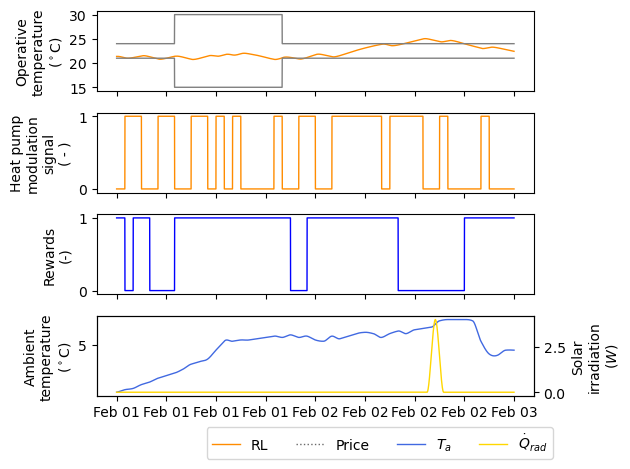

q(s,a) = 
[[2.39930188 3.81221274]
 [5.28527299 4.92873977]
 [1.82610832 0.54406137]]
-------------------------------------------------------------------
Episode number: 9, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


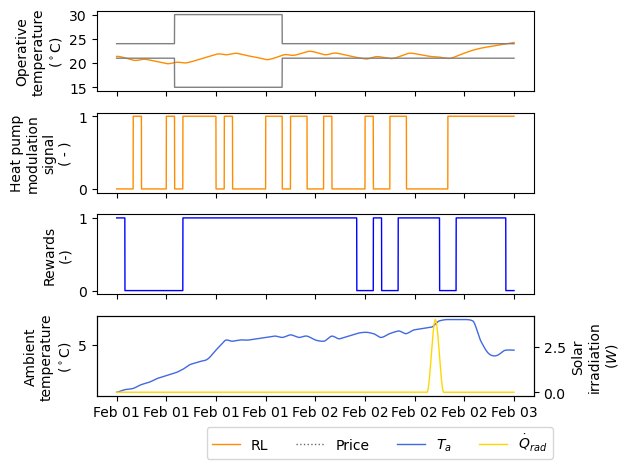

q(s,a) = 
[[2.73890406 4.37192188]
 [5.29926269 5.23581621]
 [1.82610832 0.54406137]]
-------------------------------------------------------------------
Episode number: 10, starting day: 31.0 (from beginning of the year)


C:\Users\irmak\Documents\GitHub\RL_ex\boptestGymService\examples\test_and_plot.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rewards_time_days = np.arange(df['time'][0],


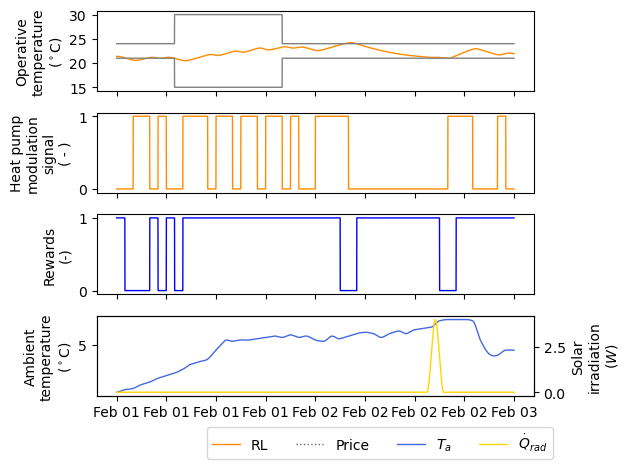

q(s,a) = 
[[2.73890406 4.61083728]
 [5.92547254 5.53927685]
 [2.13980475 0.54406137]]


In [21]:
model.learn(total_episodes=10)

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
C:\Users\irmak\AppData\Local\Temp\ipykernel_23324\1905087273.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_zlabel('$\mathbf{q(s,a)}$', labelpad=0,  fontsize=15)


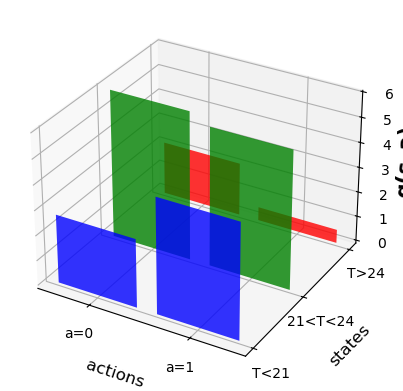

In [22]:
import matplotlib.pyplot as plt

acts   = ['a=0','a=1']
stas   = ['T<21', '21<T<24', 'T>24']
colors = ['b',    'g',       'r']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('actions',           labelpad=6,  fontsize=12)
ax.set_ylabel('states',            labelpad=10, fontsize=12)
ax.set_zlabel('$\mathbf{q(s,a)}$', labelpad=0,  fontsize=15)
plt.xticks(ticks=range(len(acts)), labels=acts)
plt.yticks(ticks=range(len(stas)), labels=stas)

for i, s in enumerate(stas):
  x = np.arange(len(acts))
  h = model.q[i,:]

  # Set color
  color = [colors[i]]*len(acts)

  # Plot the 3D bar graph
  ax.bar(x, h, zs=i, zdir='y', color=color, alpha=0.8)

plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\irmak\AppData\Local\Temp\ipykernel_23324\2849865350.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathbf{v(s)}$', labelpad=0,  fontsize=15)


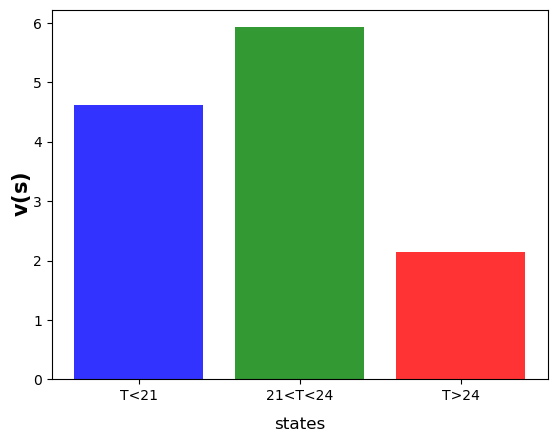

In [23]:
# Compute the state-value function
v = np.amax(model.q, axis=1)

# Plot state-value function
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_xlabel('states', labelpad=10, fontsize=12)
ax.set_ylabel('$\mathbf{v(s)}$', labelpad=0,  fontsize=15)
plt.xticks(ticks=range(len(stas)), labels=stas)
x = np.arange(len(stas))
ax.bar(x, v, color=colors, alpha=0.8)
plt.show()

In [24]:
env.stop()
env = BoptestGymEnvCustomReward(url                   = url,
                                testcase              = 'bestest_hydronic_heat_pump',
                                actions               = ['oveHeaPumY_u'],
                                observations          = {'reaTZon_y':(lower_setp,upper_setp)},
                                random_start_time     = False,
                                start_time            = 31*24*3600,
                                max_episode_length    = 24*3600,
                                warmup_period         = 24*3600,
                                step_period           = 3600)
env = DiscretizedActionWrapper(env, n_bins_act=1)
env = DiscretizedObservationWrapper(env, n_bins_obs=3, outs_are_bins=True)

done = False
obs, _ = env.reset()

from IPython.display import clear_output
while not done:
  # Clear the display output at each step
  clear_output(wait=True)
  # Compute control signal
  action = model.predict(obs, deterministic=True)
  # Print the current operative temperature and decided action
  print('-------------------------------------------------------------------')
  print('State  [Bin #]  = {:.0f}'.format(obs))
  print('Action [ - ]    = {:.0f}'.format(action))
  print('-------------------------------------------------------------------')
  # Implement action
  obs,reward,terminated,truncated,info = env.step(action) # send the action to the environment
  done = (terminated or truncated)

-------------------------------------------------------------------
State  [Bin #]  = 1
Action [ - ]    = 0
-------------------------------------------------------------------


In [25]:
env.get_kpis()

{'tdis_tot': 1.741814571742692,
 'idis_tot': 0,
 'ener_tot': 0.17501251008682203,
 'cost_tot': 0.0443656713070094,
 'emis_tot': 0.02922708918449929,
 'pele_tot': 0.019907644464042158,
 'pgas_tot': None,
 'pdih_tot': None,
 'time_rat': 0.00039872929669808647}